<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Trials

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
from optuna.storages import RDBStorage

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Connect Database

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RDBStorage.html#optuna.storages.RDBStorage

In [4]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [5]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18  220 trials 'distilbert-base-german-cased'
2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-19  133 trials 'distilbert-base-german-cased_multi_bs8'
2021-12-20   38 trials 'distilbert-base-german-cased_multi_mcc'


## Load Study

In [6]:
study = optuna.load_study('distilbert-base-german-cased_multi_mcc', storage)

best = [t.number for t in study.best_trials]
print(best)
study.best_trials

[1, 27]


[FrozenTrial(number=1, values=[0.3723558187484741, 0.8662979784184075], datetime_start=datetime.datetime(2021, 12, 20, 13, 7, 38, 227193), datetime_complete=datetime.datetime(2021, 12, 20, 13, 13, 18, 39444), params={'learning_rate': 9.027375856819522e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 16, 'weight_decay': 0.0013772751568888668}, distributions={'learning_rate': LogUniformDistribution(high=0.0001, low=1e-05), 'num_train_epochs': CategoricalDistribution(choices=(1,)), 'per_device_train_batch_size': CategoricalDistribution(choices=(16, 32)), 'weight_decay': LogUniformDistribution(high=0.01, low=0.001)}, user_attrs={'eval_acc': 0.8832684824902723, 'eval_f1': 0.8825181026801069, 'eval_loss': 0.3723558187484741, 'eval_mcc': 0.8662979784184075, 'eval_precision': 0.8818231758016373, 'eval_recall': 0.8836296476513154, 'eval_runtime': 9.9638, 'eval_samples_per_second': 103.173, 'eval_steps_per_second': 6.524}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, t

## Analyze Complete Trials

In [7]:
from optuna.trial import TrialState

complete_trials = [t for t in study.get_trials() if t.state==TrialState.COMPLETE]

In [8]:
# create DataFrames
index = [t.number for t in complete_trials]
trial_metrics_df = pd.DataFrame([t.user_attrs for t in complete_trials], index=index)
trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss")
trial_df["best"] = trial_df.index.isin(best)
trial_params_df["eval_loss"] = trial_metrics_df["eval_loss"]
display(trial_df.head())

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_acc,eval_f1,eval_loss,eval_mcc,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,best
27,0.000091,1,32,0.004998,0.877432,0.876126,0.370018,0.859585,0.876942,0.875907,9.6551,106.472,3.418,True
11,0.000077,1,16,0.002373,0.875486,0.875391,0.370656,0.857377,0.876063,0.875288,9.9768,103.039,6.515,False
1,0.000090,1,16,0.001377,0.883268,0.882518,0.372356,0.866298,0.881823,0.883630,9.9638,103.173,6.524,True
5,0.000069,1,16,0.009443,0.872568,0.870155,0.377273,0.854060,0.870085,0.870939,9.9676,103.134,6.521,False
6,0.000095,1,16,0.001689,0.872568,0.871629,0.382425,0.854086,0.871906,0.872420,9.9940,102.861,6.504,False


In [9]:
import plotly.express as px
fig = px.parallel_coordinates(trial_params_df, color="eval_loss", 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [10]:
fig = optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
fig.update_layout(autosize=False, width=800, height=350)
fig.show()

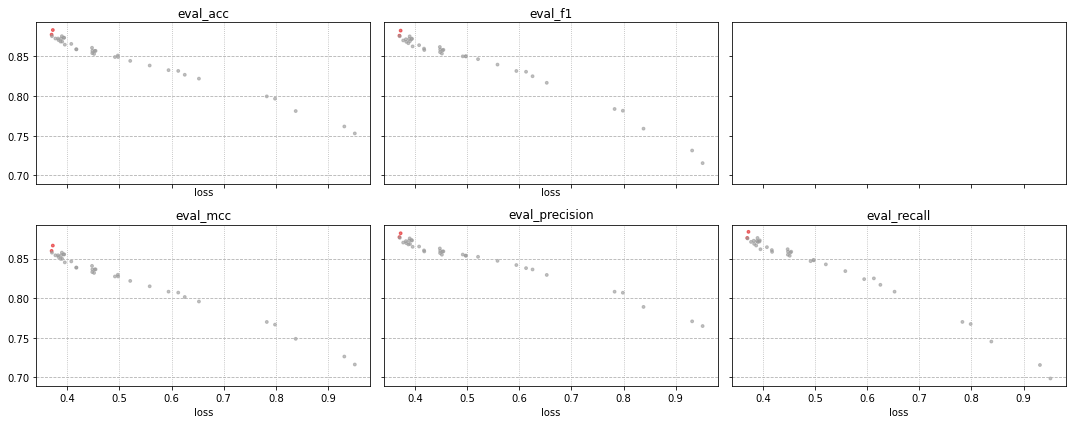

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(trial_df.eval_loss, trial_df[col], c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

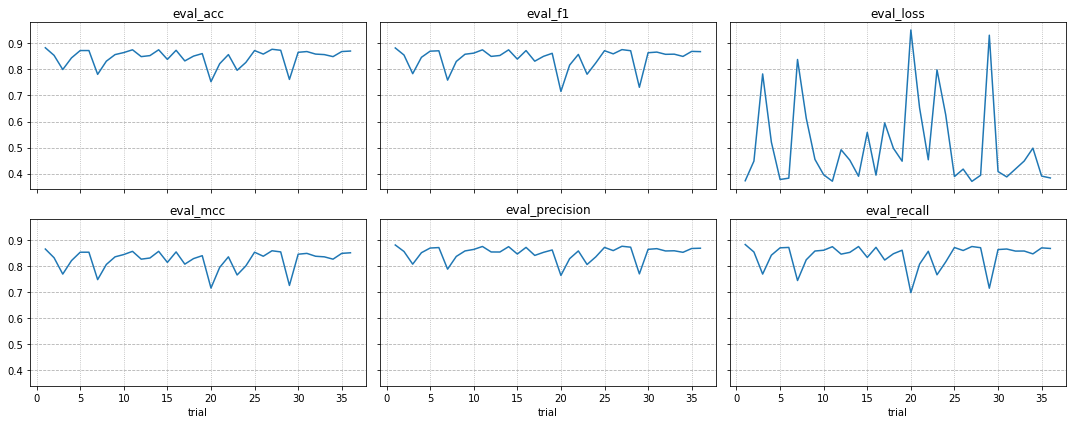

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()